In [1]:
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from rdkit.Chem import AllChem, DataStructs
import json
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
import tensorflow as tf

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_classification
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision

2023-07-04 15:56:31.262042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 15:56:34.844753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
g = nx.read_graphml("./graph/train_graph.gml")
species_features_dummy = pd.read_csv("./data/species_features.csv.gz", index_col=0).astype('uint8')
#species_features_dummy = pd.read_csv("./data/species_BaseNEncoder.csv.gz", index_col=0)
#species_features_dummy = pd.read_csv("./data/species_Multi_dim_scale.csv.gz", index_col=0)
molecule_features_dummy = pd.read_csv("./data/molecule_features.csv.gz", index_col=0).astype("uint8")
df_agg = pd.read_csv("./data/lotus_agg_train.csv.gz", index_col=0)
#molecule_features_dummy = pd.read_csv("./data/molecule_features_dummy.csv.gz", index_col=0).astype('int8')

In [3]:
species_test = species_features_dummy[~species_features_dummy.index.isin(df_agg.organism_name)].index
mol_test = molecule_features_dummy[~molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)].index

In [4]:
species_feat = species_features_dummy[species_features_dummy.index.isin(df_agg.organism_name)]
molecule_feat = molecule_features_dummy[molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)]

In [5]:
G = StellarGraph.from_networkx(g,
                               node_features={'species':species_feat,
                                              'molecule': molecule_feat},
                              dtype='uint8')
print(G.info())
G.check_graph_for_ml()

StellarDiGraph: Directed multigraph
 Nodes: 162374, Edges: 700916

 Node types:
  molecule: [127088]
    Features: float32 vector, length 27
    Edge types: molecule-present_in->species
  species: [35286]
    Features: float32 vector, length 80
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [350458]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [350458]
        Weights: all 1 (default)
        Features: none


In [6]:
batch_size = 128 #default: 200
epochs = 50 #default: 20
num_samples = [3, 1]
num_workers = multiprocessing.cpu_count()-2

In [7]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=False, edge_label="has"
)

Network has 350458 edges of type has
Network has 350458 edges of type has
** Sampled 35045 positive and 35045 negative edges. **


In [8]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=False, edge_label="has"
)

Network has 315413 edges of type has
Network has 315413 edges of type has
** Sampled 31541 positive and 31541 negative edges. **


In [9]:
print(G_train.info())

StellarDiGraph: Directed multigraph
 Nodes: 162374, Edges: 634330

 Node types:
  molecule: [127088]
    Features: float32 vector, length 27
    Edge types: molecule-present_in->species
  species: [35286]
    Features: float32 vector, length 80
    Edge types: species-has->molecule

 Edge types:
    molecule-present_in->species: [350458]
        Weights: all 1 (default)
        Features: none
    species-has->molecule: [283872]
        Weights: all 1 (default)
        Features: none


In [10]:
print(G_test.info())

StellarDiGraph: Directed multigraph
 Nodes: 162374, Edges: 665871

 Node types:
  molecule: [127088]
    Features: float32 vector, length 27
    Edge types: molecule-present_in->species
  species: [35286]
    Features: float32 vector, length 80
    Edge types: species-has->molecule

 Edge types:
    molecule-present_in->species: [350458]
        Weights: all 1 (default)
        Features: none
    species-has->molecule: [315413]
        Weights: all 1 (default)
        Features: none


In [11]:
train_gen = HinSAGELinkGenerator(G_train,
                                 batch_size=batch_size,
                                 num_samples=num_samples,
                                 head_node_types=["species", "molecule"],
                                seed=42)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True, seed=42)

In [12]:
test_gen = HinSAGELinkGenerator(G_test,
                                batch_size=batch_size,
                                num_samples=num_samples,
                                head_node_types=["species", "molecule"],
                               seed=42)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test, seed=42)

In [13]:
hinsage_layer_sizes = [1024, 1024]
hinsage = HinSAGE(layer_sizes=hinsage_layer_sizes,
                  generator=train_gen,
                  bias=True,
                  dropout=0.3,
                 activations=['elu','selu'])

In [14]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = hinsage.in_out_tensors()

/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [15]:
prediction = link_classification(output_dim=1,
                                 output_act="sigmoid",
                                 edge_embedding_method="l1")(x_out)

link_classification: using 'l1' method to combine node embeddings into edge embeddings


In [16]:
model = keras.Model(inputs=x_inp, outputs=prediction)

initial_learning_rate = 0.1
final_learning_rate = 0.00001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(edge_ids_train.shape[0]/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.binary_crossentropy,
    metrics=["AUC"],
)

In [17]:
init_train_metrics = model.evaluate(train_flow, workers=num_workers, verbose=2)
init_test_metrics = model.evaluate(test_flow, workers=num_workers, verbose=2)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

493/493 - 9s - loss: 0.6942 - auc: 0.4744 - 9s/epoch - 17ms/step
548/548 - 8s - loss: 0.6941 - auc: 0.4759 - 8s/epoch - 15ms/step

Train Set Metrics of the initial (untrained) model:
	loss: 0.6942
	auc: 0.4744

Test Set Metrics of the initial (untrained) model:
	loss: 0.6941
	auc: 0.4759


In [18]:
callbacks = keras.callbacks.EarlyStopping(monitor="val_loss",
                                          patience=7,
                                          mode="auto",
                                          restore_best_weights=True)

history = model.fit(train_flow,
                    epochs=epochs,
                    workers=num_workers,
                    validation_data=test_flow,
                    verbose=2,
                    callbacks=[callbacks],
                    validation_split=0.0,
                    shuffle=True
                   )

Epoch 1/50
493/493 - 35s - loss: 0.5682 - auc: 0.7597 - val_loss: 0.4320 - val_auc: 0.8885 - 35s/epoch - 72ms/step
Epoch 2/50
493/493 - 33s - loss: 0.4063 - auc: 0.8934 - val_loss: 0.3176 - val_auc: 0.9381 - 33s/epoch - 67ms/step
Epoch 3/50
493/493 - 35s - loss: 0.3311 - auc: 0.9309 - val_loss: 0.2587 - val_auc: 0.9583 - 35s/epoch - 71ms/step
Epoch 4/50
493/493 - 34s - loss: 0.2979 - auc: 0.9439 - val_loss: 0.2425 - val_auc: 0.9626 - 34s/epoch - 68ms/step
Epoch 5/50
493/493 - 33s - loss: 0.2716 - auc: 0.9534 - val_loss: 0.2136 - val_auc: 0.9707 - 33s/epoch - 66ms/step
Epoch 6/50
493/493 - 33s - loss: 0.2547 - auc: 0.9590 - val_loss: 0.2044 - val_auc: 0.9738 - 33s/epoch - 67ms/step
Epoch 7/50
493/493 - 34s - loss: 0.2360 - auc: 0.9648 - val_loss: 0.1910 - val_auc: 0.9767 - 34s/epoch - 69ms/step
Epoch 8/50
493/493 - 34s - loss: 0.2260 - auc: 0.9676 - val_loss: 0.1851 - val_auc: 0.9784 - 34s/epoch - 70ms/step
Epoch 9/50
493/493 - 33s - loss: 0.2146 - auc: 0.9705 - val_loss: 0.1754 - val_a

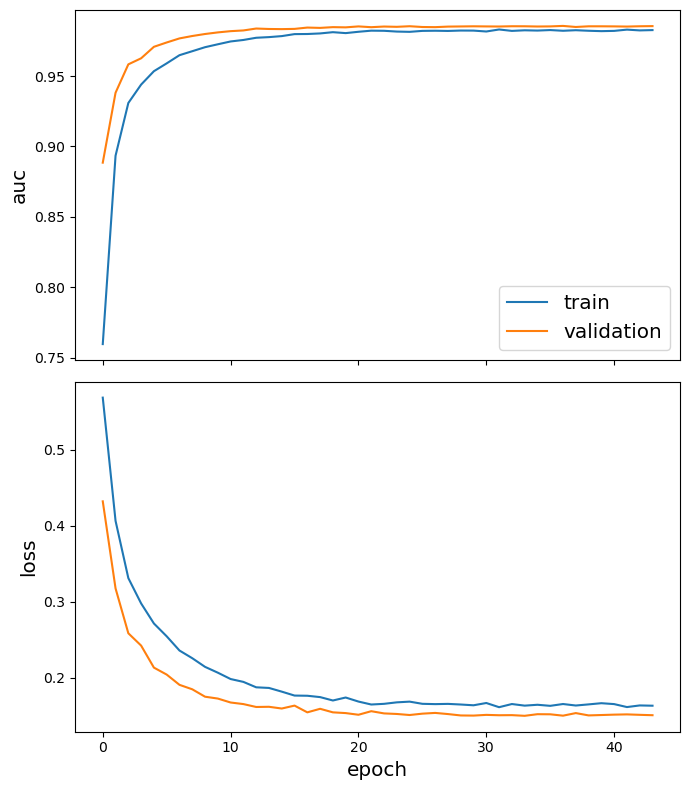

In [19]:
sg.utils.plot_history(history)

In [20]:
train_metrics = model.evaluate(train_flow, verbose=2)
test_metrics = model.evaluate(test_flow, verbose=2)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

493/493 - 8s - loss: 0.1173 - auc: 0.9904 - 8s/epoch - 16ms/step
548/548 - 9s - loss: 0.1529 - auc: 0.9850 - 9s/epoch - 16ms/step

Train Set Metrics of the trained model:
	loss: 0.1173
	auc: 0.9904

Test Set Metrics of the trained model:
	loss: 0.1529
	auc: 0.9850


In [21]:
def predict(model, flow, iterations=10):
    predictions = []
    for _ in range(iterations):
        predictions.append(model.predict(flow, workers=-1).flatten())

    return np.mean(predictions, axis=0)

In [23]:
test_pred = HinSAGELinkGenerator(G,
                                 batch_size=batch_size,
                                num_samples=num_samples,
                                head_node_types=["species", "molecule"],
                                seed=42).flow(edge_ids_test, edge_labels_test, seed=42)

In [24]:
predictions = predict(model, test_pred)

548/548 [==============================] - 9s 16ms/step


In [25]:
middle = int(len(predictions)/2)

In [26]:
np.mean(predictions[:middle])

0.947129

In [27]:
np.mean(predictions[middle:])

0.08486995

In [28]:
test = predictions[(predictions>0.5) | (predictions<0.5)]
test = test>0.5

In [29]:
test = test.astype('int8')

(array([28757.,  1700.,  1005.,   820.,   749.,   780.,  1006.,  1586.,
         3811., 29876.]),
 array([2.75852390e-08, 9.99898389e-02, 1.99979648e-01, 2.99969465e-01,
        3.99959266e-01, 4.99949068e-01, 5.99938869e-01, 6.99928701e-01,
        7.99918532e-01, 8.99908304e-01, 9.99898136e-01]),
 <BarContainer object of 10 artists>)

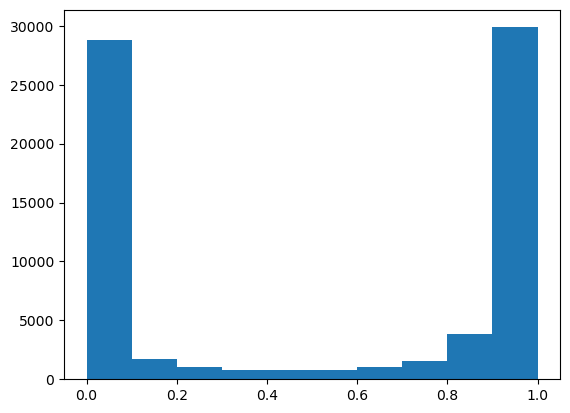

In [30]:
plt.hist(predictions)

In [31]:
np.where((predictions>0.9) | (predictions<0.1))

(array([    2,     3,     5, ..., 70086, 70087, 70088]),)

In [32]:
sum(test == edge_labels_test[np.where((predictions>0.5) | (predictions<0.5))])/len(test)

0.9638464830931659

In [33]:
len(test)/len(predictions)

1.0

In [34]:
model.save(f"./model/batch_{batch_size}_layer_{hinsage_layer_sizes[0]}_s_to_m")

INFO:tensorflow:Assets written to: ./model/batch_128_layer_1024_s_to_m/assets


INFO:tensorflow:Assets written to: ./model/batch_128_layer_1024_s_to_m/assets
